# Twitter Sentiment Analysis - Climate Change Tweets

Goal for the model isi to distinguish tweets between whether the tweet is factual news about climate change, supporting the beliefs that climate change is caused by mankind, neutral, or refusing to believe that climate change iis impacted by human activity.

In [3]:
#IMPORT PACKAGES

import numpy as np
import pandas as pd
from os import makedirs
from os import path
import math
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from pydataset import data
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import plot_tree, DecisionTreeClassifier

import pickle
import json

In [54]:
df = pd.read_csv('twitter_sentiment_data.csv')

In [55]:
#SET UP LABEL DATAFRAME FOR FUTURE REFERENCE

sentiment = [-1, 0, 1, 2]
sentiment_label = ['Anti', 'Neutral', 'Pro', 'Factual']
label_descriptions = ['The Tweet does not believe in man-made climate change',
                      'The tweet neither refutes or affirms the beliefs of man-made climate change',
                      'The tweet supports the belief that climate change is caused by human intervention',
                      'The tweet is linked to factual news about climate change']

df_labels = pd.DataFrame(list(zip(sentiment, sentiment_label, label_descriptions)), columns = ['Label','Name', 'Description'])

In [56]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the p...,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...",793125156185137153


* **Data Description**: The data has a very simple structure with only 2 features including the tweet itself and the ID of the tweet. The sentiment column (target variable) shows the sentiment label assigned to the tweet based on the discretion of 3 reviewers.

In [86]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


(43943, 3)

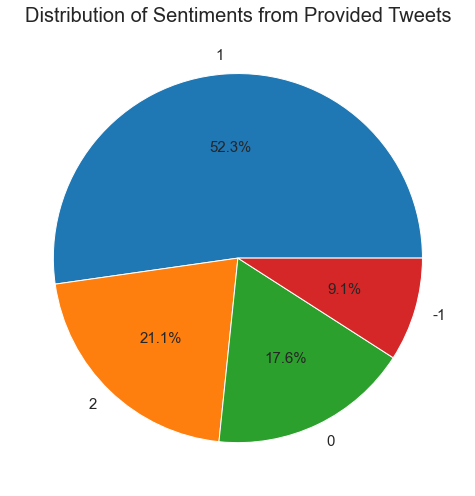

In [58]:
#PIE CHART OF SENTIMENT ANALYSIS

plt.figure(figsize=(7,7))
plt.pie(df.sentiment.value_counts().values, labels = df.sentiment.value_counts().index, autopct= '%2.1f%%', textprops = {'fontsize': 15})
plt.title('Distribution of Sentiments from Provided Tweets',fontsize = 20)
plt.tight_layout()
plt.show()

* **Pie chart shows the distribution of the data. A majority of the tweets indicate a support of man-made climate change. 10% of the total tweets did actively claim that climate change cannot be impacted by human activity.**

In [59]:
df_tweets = df['message']

## Tokenization - Split Tweets into an Array of Words

In [60]:
def generateTokenizationArray(sentence_array):
    '''
    Create lower case array of words with no punctuatiion
    :param sentences: array or series of tweets
    :return: lower case array of words with no punctuation
    '''
    tokenizer = RegexpTokenizer(r'\w+')
    tokenizedArray = []

    for i in range(0, len(sentence_array)):

        #sentences to be in lower case
        sentence = sentence_array[i].lower()

        #spliit sentence inito array of words with no punctuatiion
        words = tokenizer.tokenize(sentence)

        #Append word array to list
        tokenizedArray.append(words)

    return tokenizedArray

In [88]:
tokenizedLi = generateTokenizationArray(df_tweets)

tokenizedLi

[['tiniebeany',
  'climate',
  'change',
  'is',
  'an',
  'interesting',
  'hustle',
  'as',
  'it',
  'was',
  'global',
  'warming',
  'but',
  'the',
  'planet',
  'stopped',
  'warming',
  'for',
  '15',
  'yes',
  'while',
  'the',
  'suv',
  'boom'],
 ['rt',
  'natgeochannel',
  'watch',
  'beforetheflood',
  'right',
  'here',
  'as',
  'leodicaprio',
  'travels',
  'the',
  'world',
  'to',
  'tackle',
  'climate',
  'change',
  'https',
  't',
  'co',
  'lkdehj3tnn',
  'httã',
  'â',
  'â'],
 ['fabulous',
  'leonardo',
  'dicaprio',
  's',
  'film',
  'on',
  'climate',
  'change',
  'is',
  'brilliant',
  'do',
  'watch',
  'https',
  't',
  'co',
  '7rv6brmxjw',
  'via',
  'youtube'],
 ['rt',
  'mick_fanning',
  'just',
  'watched',
  'this',
  'amazing',
  'documentary',
  'by',
  'leonardodicaprio',
  'on',
  'climate',
  'change',
  'we',
  'all',
  'think',
  'thisã',
  'â',
  'â',
  'https',
  't',
  'co',
  'knste8k8im'],
 ['rt',
  'cnalive',
  'pranita',
  'biswasi',

## Stop Word Removal

Stop words are words like "the", "an", "a", and "an." which do not add any significance values in the query search.

In [89]:
nltk.download('stopwords')

def removeSW(tokenizedList):

    stopWords = set(stopwords.words('english'))
    shorterSentences = []

    for sentence in tokenizedList:
        shorterSentence = []
        for word in sentence:
            if word not in stopWords:

                word = word.strip()

                if (len(word) > 1 and word.isdigit() == False):
                    shorterSentence.append(word)

        shorterSentences.append(shorterSentence)
    return shorterSentences

    #Return: Array of words with no punctuation or stop words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Dishant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [90]:
tokenizedRemoveStopWord = removeSW(tokenizedLi)

tokenizedRemoveStopWord = pd.Series(removeSW(tokenizedLi))

tokenizedRemoveStopWord

0        [tiniebeany, climate, change, interesting, hustle, global, warming, planet, stopped, w...
1        [rt, natgeochannel, watch, beforetheflood, right, leodicaprio, travels, world, tackle,...
2        [fabulous, leonardo, dicaprio, film, climate, change, brilliant, watch, https, co, 7rv...
3        [rt, mick_fanning, watched, amazing, documentary, leonardodicaprio, climate, change, t...
4        [rt, cnalive, pranita, biswasi, lutheran, odisha, gives, testimony, effects, climate, ...
                                                   ...                                            
43938    [dear, realdonaldtrump, yeah, right, human, mediated, climate, change, chinese, urban,...
43939                         [respective, parties, prevent, climate, change, globally, zpndebate]
43940    [rt, mikkil, un, poll, shows, climate, change, lowest, global, concerns, https, co, oo...
43941    [rt, taehbeingextra, still, believe, gif, taehyung, saved, human, race, stopped, globa...
43942    [

## Stemming

Many words in the English language are time variations of a similar root word. Potentially, this means that the sentiment algorithm can be improved by accepting different words as long as they come from the same root word.

In [91]:
def stemming(sentenceArrays):

    ps = PorterStemmer()
    stemmedSentences = []

    for sentenceArray in sentenceArrays:
        stemmedArray = []
        for word in sentenceArray:
            stemmedArray.append(ps.stem(word))

        delimeter = ' '
        sentence = delimeter.join(stemmedArray)

        stemmedSentences.append(sentence)
    return stemmedSentences

In [92]:
stemmedLi = stemming(tokenizedRemoveStopWord)

print(f"Sample sentence BEFORE stemming: \n{tokenizedRemoveStopWord[1]}")
print(f"\nSample sentence AFTER stemming: \n{stemmedLi[1]}")

Sample sentence BEFORE stemming: 
['rt', 'natgeochannel', 'watch', 'beforetheflood', 'right', 'leodicaprio', 'travels', 'world', 'tackle', 'climate', 'change', 'https', 'co', 'lkdehj3tnn', 'httã']

Sample sentence AFTER stemming: 
rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http co lkdehj3tnn httã


The stemming process allows the algorithm to process words with thhe same root equally and not cause any duplicate word queries. Cimate become climat and change become chang.

## Vectorization

The words now need to be converted back into numbers so they can be fed into various big data algorithms.

In [93]:
def vectorizeList(stemmedList, ngramRangeStart, ngramRangeEnd):

    cv = CountVectorizer(binary=True, ngram_range= (ngramRangeStart, ngramRangeEnd))
    cv.fit(stemmedList)
    X = cv.transform(stemmedList)

    return X, cv.vocabulary_

In [94]:
vectorizedTweets, vectorDictionary = vectorizeList(stemmedLi, 1, 1)

In [95]:
print(f"Sample sentence #1:\n{stemmedLi[1]}")
print(f"Sample sentence #2:\n{stemmedLi[2]}")

Sample sentence #1:
rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http co lkdehj3tnn httã
Sample sentence #2:
fabul leonardo dicaprio film climat chang brilliant watch http co 7rv6brmxjw via youtub


In [96]:
print(f"\nAfter Vectorization:\n{vectorizedTweets[1]}")


After Vectorization:
  (0, 9419)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 14222)	1
  (0, 27583)	1
  (0, 27591)	1
  (0, 35060)	1
  (0, 35653)	1
  (0, 40355)	1
  (0, 49581)	1
  (0, 50386)	1
  (0, 55654)	1
  (0, 57882)	1
  (0, 61927)	1
  (0, 63129)	1


In [97]:
vectorizedTweets.shape

(43943, 67195)

## N-Grams Method

By using the N-Grams method, we can group N numbers of words together and analyze their frequencies for the specific sentiement rating.

In [113]:
def createWordDictionary(wordDf, sentimentScore, n_size):

    resultDf = wordDf[(wordDf['sentiment'] == sentimentScore)]

    sentences = [sentence.split() for sentence in resultDf['transformedTweets']]
    wordArray = []

    for i in range(0, len(sentences)):
        wordArray += sentences[i]

    counterList = Counter(ngrams(wordArray, n_size)).most_common(80)

    counterDf = pd.DataFrame()

    delimiter = ' '
    print(f"\n***N-Gram (Sentiment : {sentimentScore})")
    for i in range(0, len(counterList)):
        counterDict = {
            "N-Gram" : delimiter.join(counterList[i][0]),
            "Occurences" : counterList[i][1]
        }

            #convvert dict to series before concating to the DataFrame
        counterDict = pd.DataFrame(counterDict, index = [0])
        counterDf = pd.concat([counterDf, counterDict], ignore_index=True)

    return counterDf

In [114]:
#BI GRAMS
SIZE = 2
#tranformed tweets columns will now need to be added to the original dataset with the stemmed data
df['transformedTweets' ] = stemmedLi
dfSub = df[['sentiment', 'transformedTweets']]


***N-Gram (Sentiment : -1)
                N-Gram  Occurences
0         climat chang        2211
1              http co        1873
2          global warm        1855
3             man made         174
4           chang http         150
5     rt stevesgoddard         118
6            warm http         114
7              al gore         103
8              http rt          91
9   rt realdonaldtrump          87
10         made climat          86
11         made global          73
12             warm rt          72
13            chang rt          66
14          chang real          65
15         warm climat          61
16           warm hoax          60
17       believ climat          54
18          chang hoax          53
19         caus global          48


<AxesSubplot:title={'center':'Top 20 Occurences of Bi-Grams of Anti Climate Change Tweets'}, xlabel='Occurences', ylabel='N-Gram'>

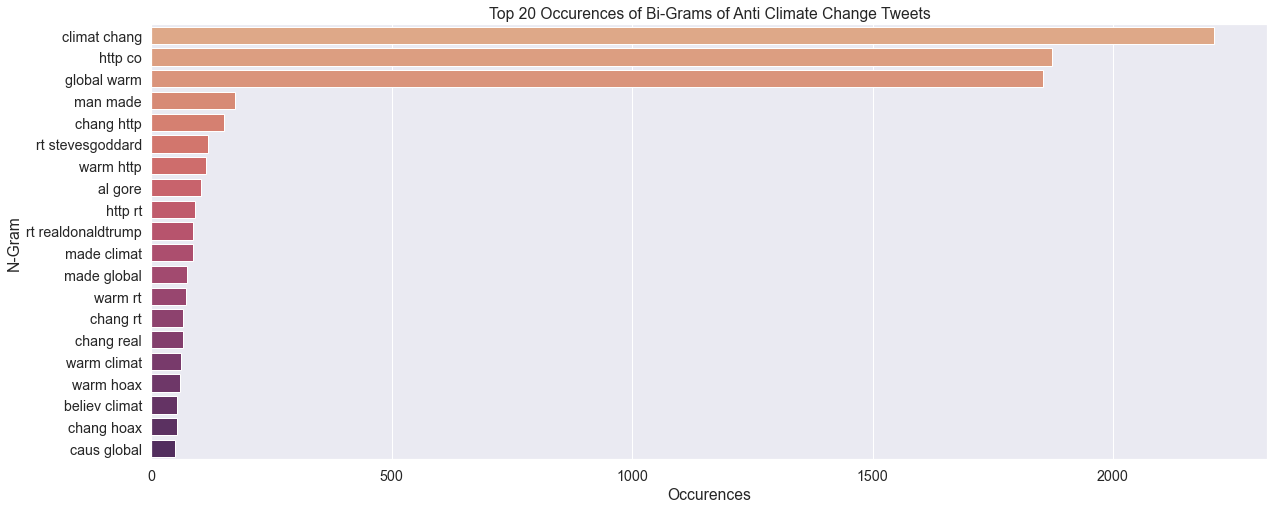

In [116]:
### TOP 20 Occurrences of Bi-Grams of Anti Climate Change Tweets (-1)
counterDfAntiTop = createWordDictionary(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale = 1.3)
plt.figure(figsize= (20,8))
plt.title('Top 20 Occurences of Bi-Grams of Anti Climate Change Tweets')
sns.set_style('darkgrid')
sns.barplot(x = 'Occurences', y = 'N-Gram', data= counterDfAntiTop , palette= 'flare')

We can see that "man-made" was common within a lot of the anti climate change tweets along with retweeting a link to a presumed anti climate change article. Many of the tweets are retweets from Steve Goddard and Donald Trump who notoriously spread misinformation in regard to climate change.


***N-Gram (Sentiment : 0)
           N-Gram  Occurences
0    climat chang        4491
1         http co        3271
2     global warm        3109
3      chang http         447
4       warm http         289
5         warm rt         236
6        chang rt         218
7     caus global         137
8       warm real         121
9         http rt         109
10  believ climat         107
11    talk climat          99
12          ðÿ ðÿ          88
13   think global          82
14   club penguin          82
15     chang real          81
16  believ global          75
17    caus climat          70
18   penguin shut          68
19     chang hoax          63


<AxesSubplot:title={'center':'Top 20 Occurences of Bi-Grams of Neutral Climate Change Tweets'}, xlabel='Occurences', ylabel='N-Gram'>

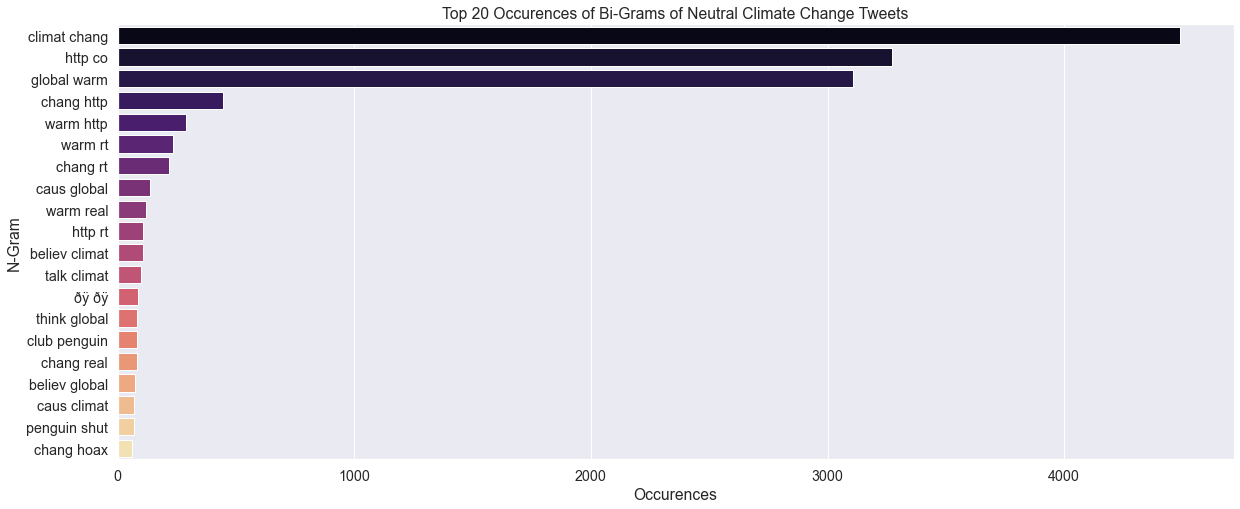

In [130]:
### TOP 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets (-1)
counterDfNeutralTop = createWordDictionary(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutralTop.head(20)
print(counterDfNeutralTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title('Top 20 Occurences of Bi-Grams of Neutral Climate Change Tweets')
sns.set_style('darkgrid')
sns.barplot(x = 'Occurences', y = 'N-Gram', data= counterDfNeutralTop , palette= 'magma')

We are finding that with the N-Size = 2 there it is difficult to discern the relationships between the sentiments and the words within the tweets, if we uop the n_gram size to 3 we may see more defined patterns within the tweets.


***N-Gram (Sentiment : -1)
                 N-Gram  Occurences
0     climat chang http         146
1         chang http co         138
2      global warm http         112
3          warm http co         105
4     made climat chang          82
5       man made climat          78
6        global warm rt          71
7      made global warm          71
8       man made global          67
9     climat chang real          65
10      climat chang rt          61
11     global warm hoax          60
12   global warm climat          59
13    climat chang hoax          52
14  believ climat chang          52
15    warm climat chang          50
16     global warm data          45
17    caus climat chang          44
18     caus global warm          44
19    global warm creat          43


<AxesSubplot:title={'center':'Top 20 Occurences of Bi-Grams of Anti Climate Change Tweets'}, xlabel='Occurences', ylabel='N-Gram'>

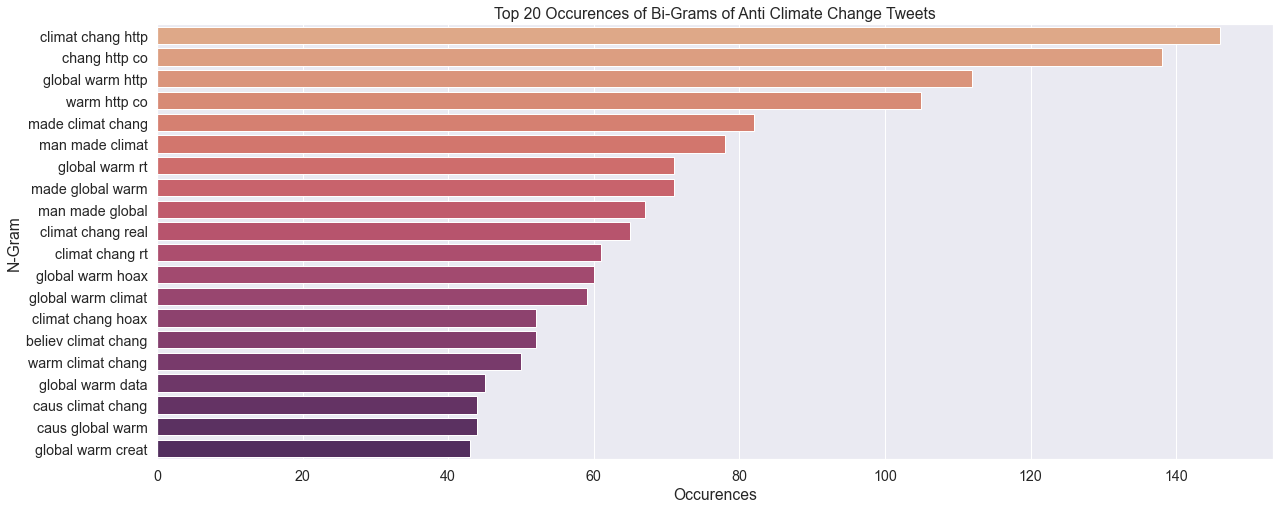

In [132]:
SIZE = 3

### TOP 20 Occurrences of Bi-Grams of Anti Climate Change Tweets (-1)
counterDfAntiTop = createWordDictionary(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale = 1.3)
plt.figure(figsize= (20,8))
plt.title('Top 20 Occurences of Bi-Grams of Anti Climate Change Tweets')
sns.set_style('darkgrid')
sns.barplot(x = 'Occurences', y = 'N-Gram', data= counterDfAntiTop , palette= 'flare')


***N-Gram (Sentiment : 0)
                 N-Gram  Occurences
0     climat chang http         444
1         chang http co         424
2      global warm http         289
3          warm http co         280
4        global warm rt         235
5       climat chang rt         214
6      caus global warm         137
7      global warm real         121
8   believ climat chang         106
9     talk climat chang          96
10    think global warm          81
11    climat chang real          81
12   believ global warm          74
13    caus climat chang          69
14    club penguin shut          68
15    climat chang hoax          63
16   think climat chang          58
17     stop global warm          57
18   fight climat chang          56
19     say climat chang          52


<AxesSubplot:title={'center':'Top 20 Occurences of Bi-Grams of Neutral Climate Change Tweets'}, xlabel='Occurences', ylabel='N-Gram'>

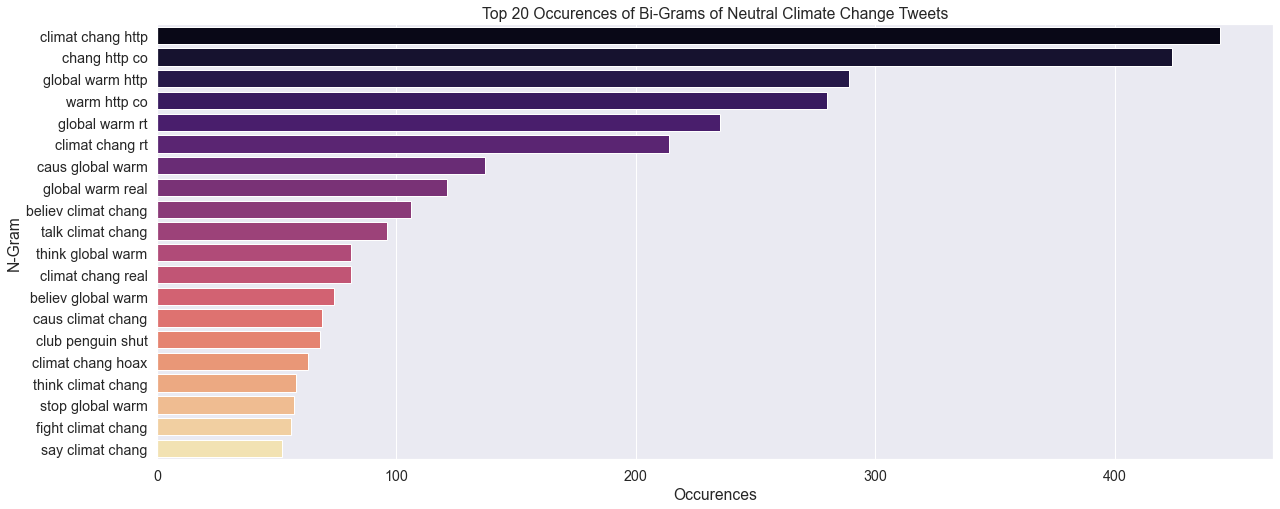

In [133]:
### TOP 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets (-1)
counterDfNeutralTop = createWordDictionary(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutralTop.head(20)
print(counterDfNeutralTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title('Top 20 Occurences of Bi-Grams of Neutral Climate Change Tweets')
sns.set_style('darkgrid')
sns.barplot(x = 'Occurences', y = 'N-Gram', data= counterDfNeutralTop , palette= 'magma')

A distinct difference can be seen between the tweets against climate change and neutral for climate change. For anti climate change tweets its commonly found that tweets have the phrases "man climate change" and "manmade climate change". For neutral on climate change we see tweets with the phrases "cause global warming" and "believe climate change".


***N-Gram (Sentiment : 1)
                      N-Gram  Occurences
0          climat chang http        2787
1              chang http co        2635
2        believ climat chang        1422
3         fight climat chang         822
4        climat chang denier         711
5          climat chang real         679
6      husband believ climat         512
7               think go die         510
8             go die husband         510
9         die husband believ         510
10  rt stephenschlegel think         507
11  stephenschlegel think go         507
12           http co sjofonã         506
13          global warm http         480
14              warm http co         470
15           climat chang rt         465
16             co sjofonã rt         435
17         deni climat chang         428
18        tackl climat chang         385
19       combat climat chang         366


<AxesSubplot:title={'center':'Top 20 Occurences of Bi-Grams of Neutral Climate Change Tweets'}, xlabel='Occurences', ylabel='N-Gram'>

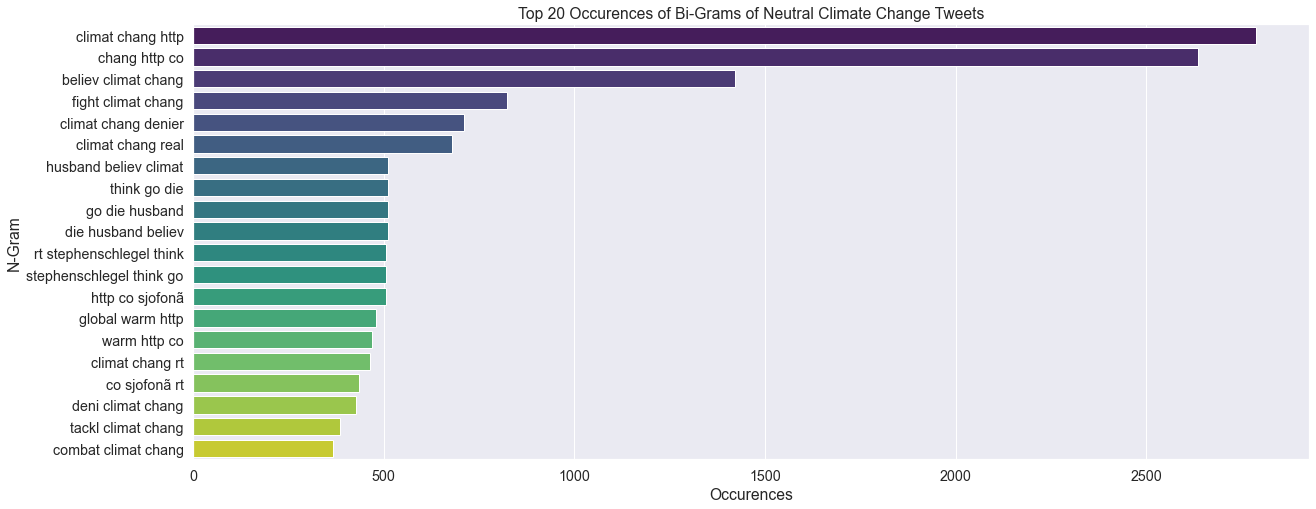

In [135]:
### TOP 20 Occurrences of Bi-Grams of Positive Climate Change Tweets (-1)
counterDfPositiveTop = createWordDictionary(dfSub, 1, SIZE)
counterDfPositiveTop = counterDfPositiveTop.head(20)
print(counterDfPositiveTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title('Top 20 Occurences of Bi-Grams of Neutral Climate Change Tweets')
sns.set_style('darkgrid')
sns.barplot(x = 'Occurences', y = 'N-Gram', data= counterDfPositiveTop , palette= 'viridis')


***N-Gram (Sentiment : 2)
                    N-Gram  Occurences
0        climat chang http        1998
1            chang http co        1964
2       fight climat chang         355
3         global warm http         348
4             warm http co         346
5       trump climat chang         244
6               http co rt         126
7       tackl climat chang         125
8         say climat chang         124
9         due climat chang         122
10            news http co         121
11             say http co         121
12       pari climat chang         117
13     climat chang polici         116
14     action climat chang          96
15     effect climat chang          88
16      climat chang could          82
17           studi http co          81
18  climat chang agreement          80
19       talk climat chang          79


<AxesSubplot:title={'center':'Top 20 Occurences of Bi-Grams of Neutral Climate Change Tweets'}, xlabel='Occurences', ylabel='N-Gram'>

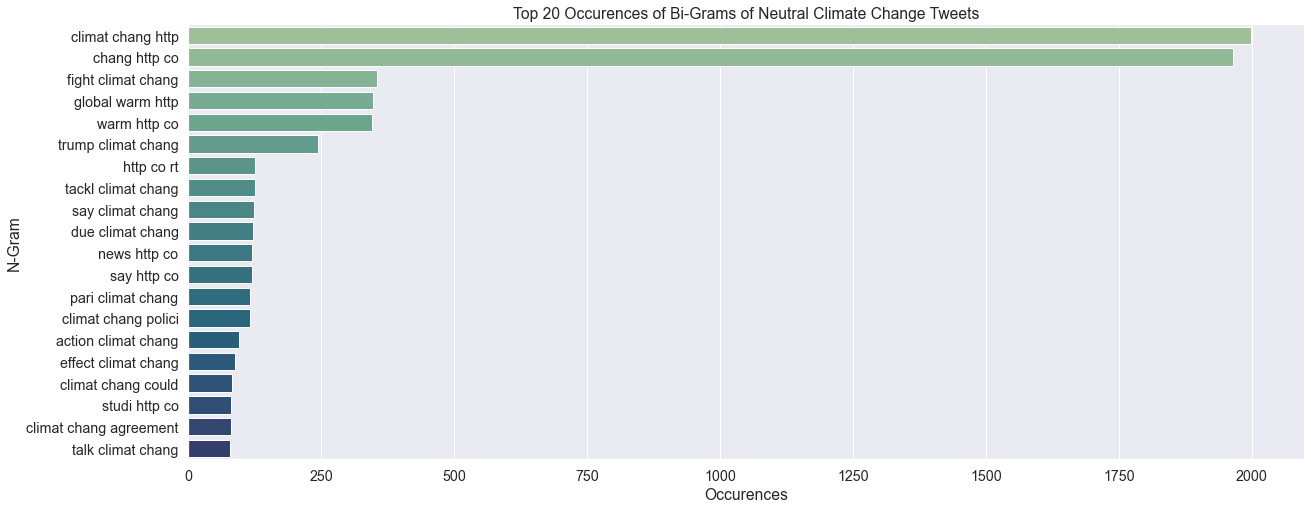

In [136]:
### TOP 20 Occurrences of Bi-Grams of News-Worthy Climate Change Tweets (-1)
counterDfNewsTop = createWordDictionary(dfSub, 2, SIZE)
counterDfNewsTop = counterDfNewsTop.head(20)
print(counterDfNewsTop)

sns.set(font_scale=1.3)
plt.figure(figsize=(20, 8))
plt.title('Top 20 Occurences of Bi-Grams of Neutral Climate Change Tweets')
sns.set_style('darkgrid')
sns.barplot(x = 'Occurences', y = 'N-Gram', data= counterDfNewsTop, palette= 'crest')

## Build Functions for Model Testing and Evaluation

In [123]:
def evaluateModel(model, X_test, y_test, title):

    print("\n***" + title + "***")

    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average = 'weighted')
    precision = metrics.precision_score(y_test, predictions, average= 'weighted')
    f1 = metrics.f1_score(y_test, predictions, average= 'weighted')

    clsScoreDict = {
        'accuracy' :accuracy,
        'recall' : recall,
        'precision':precision,
        'f1 score': f1
    }

    print('Accuracy: ' + str(accuracy))
    print('Recall: ' + str(recall))
    print('Precision: ' + str(precision))
    print('F1: ' + str(f1))

    return clsScoreDict

In [124]:
def modelPrediciton(X, target, model):

    modelType = model.__class__.__name__

    X_train, X_test, y_train, y_test = train_test_split(X, target, train_size =0.75)

    classificationModel = model.fit(X_train, y_train)
    clsScoreDict = evaluateModel(classificationModel, X_test, y_test, modelType)

    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict

In [128]:
def formattedConfusionMat(y_test, y_predicted):

    cm = metrics.confusion_matrix(y_test.values, y_predicted)
    print(cm)

    Index = ['ACTUAL: -1','ACTUAL: 0','ACTUAL: 1','ACTUAL: 2']
    Columns = ['PREDICTED: -1','PREDICTED: 0','PREDICTED: 1','PREDICTED: 2' ]

    df = pd.DataFrame(cm,index= Index, columns = Columns)
    plt.figure(figsize=(4,4))

    ax = sns.heatmap(df, cmap = 'Greens', annot= True, fmt = 'g')
    bottom, top = ax.get_ylim()
    ax.set(title = 'Tweet Review Sentiment Analysis')
    ax.set_ylim(bottom+0.5, top -0.5)
    ax.set_xticks(ax.get_xticklabels(), rotation = 0, horizontalaliginment = 'right')
    ax.set_yticks(ax.get_yticklabels(), rotation = 0, horizontalaliginment = 'right')

## Testing Classification Models on Training Data

### Logistic Regression



***LogisticRegression***
Accuracy: 0.731931549244493
Recall: 0.731931549244493
Precision: 0.7268094265798883
F1: 0.7262667032059417
[[ 486  179  245   60]
 [  83 1003  708  143]
 [  87  441 4832  384]
 [  19   71  525 1720]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TypeError: '<' not supported between instances of 'Text' and 'Text'

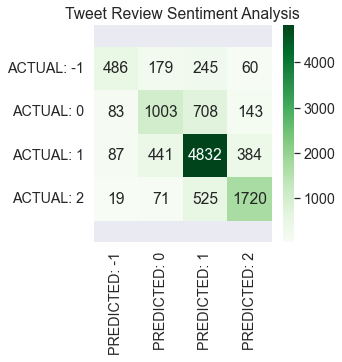

In [139]:
model = LogisticRegression()

X_test, y_test, y_predicted, lrScoreDict = modelPrediciton(vectorizedTweets, df['sentiment'], model)
formattedConfusionMat(y_test, y_predicted)

### Decision Tree


***DecisionTreeClassifier***
Accuracy: 0.6416348079373748
Recall: 0.6416348079373748
Precision: 0.6328691887189523
F1: 0.6351097853903591
[[ 406  157  373   87]
 [ 124  844  868  151]
 [ 185  560 4336  659]
 [  57  102  614 1463]]


TypeError: '<' not supported between instances of 'Text' and 'Text'

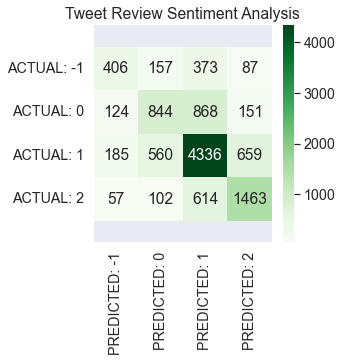

In [140]:
model = DecisionTreeClassifier()

X_test, y_test, y_predicted, dtScoreDict = modelPrediciton(vectorizedTweets, df['sentiment'], model)
formattedConfusionMat(y_test, y_predicted)

### K-Nearest Neighbors


***KNeighborsClassifier***
Accuracy: 0.4178955033679228
Recall: 0.4178955033679228
Precision: 0.5987971768854727
F1: 0.43671430071666284
[[ 201  633  114    8]
 [ 148 1470  262   26]
 [ 243 3222 2185  132]
 [  96  862  649  735]]


TypeError: '<' not supported between instances of 'Text' and 'Text'

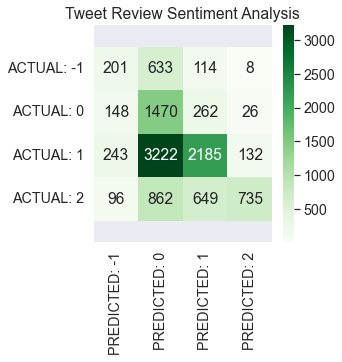

In [141]:
model = KNeighborsClassifier()

X_test, y_test, y_predicted, knnScoreDict = modelPrediciton(vectorizedTweets, df['sentiment'], model)
formattedConfusionMat(y_test, y_predicted)

## Create Binary File for Export

In [1]:
def modelPrediciton(X, target, model):

    modelType = model.__class__.__name__

    X_train, X_test, y_train, y_test = train_test_split(X, target, train_size =0.75)

    classificationModel = model.fit(X_train, y_train)

    # save model to a pickle file
    # create directory for models
    if (not path.exists("./model")):
        makedirs('./model')
    pickle.dump(classificationModel, open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "wb"))

    # load model
    loadedModel = pickle.load(open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "rb"))

    clsScoreDict = evaluateModel(loadedModel, X_test, y_test, modelType)

    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict